In [1]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve
from itertools import cycle
from sklearn.preprocessing import label_binarize


In [30]:
model = tf.keras.models.load_model('./transformer_1block_new_data')
model.summary()

Model: "transformer_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_encoding (Posit  multiple                  134560    
 ionalEncoding)                                                  
                                                                 
 transformer_block (Transfo  multiple                  1952      
 rmerBlock)                                                      
                                                                 
 dense_1 (Dense)             multiple                  1056      
                                                                 
 dense_2 (Dense)             multiple                  99        
                                                                 
Total params: 137667 (537.76 KB)
Trainable params: 137667 (537.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [3]:
features = np.load('./preprocessing_chip-seq/three_classes_combined_tokenized/feature_matrix_tokenized.npy')
targets = np.load('./preprocessing_chip-seq/three_classes_combined_tokenized/target_variable.npy')

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42, stratify=targets)

In [5]:
y_prob = model.predict(X_test)
y_prob

747/747 [==============================] - 18s 23ms/step


array([[9.99912381e-01, 2.51754445e-05, 6.24269960e-05],
       [6.45332457e-03, 1.12973586e-01, 8.80573094e-01],
       [1.08228379e-03, 2.83200175e-01, 7.15717554e-01],
       ...,
       [1.23614352e-03, 6.01312637e-01, 3.97451252e-01],
       [9.99181569e-01, 2.35240135e-04, 5.83157933e-04],
       [2.31224042e-03, 5.42832725e-02, 9.43404436e-01]], dtype=float32)

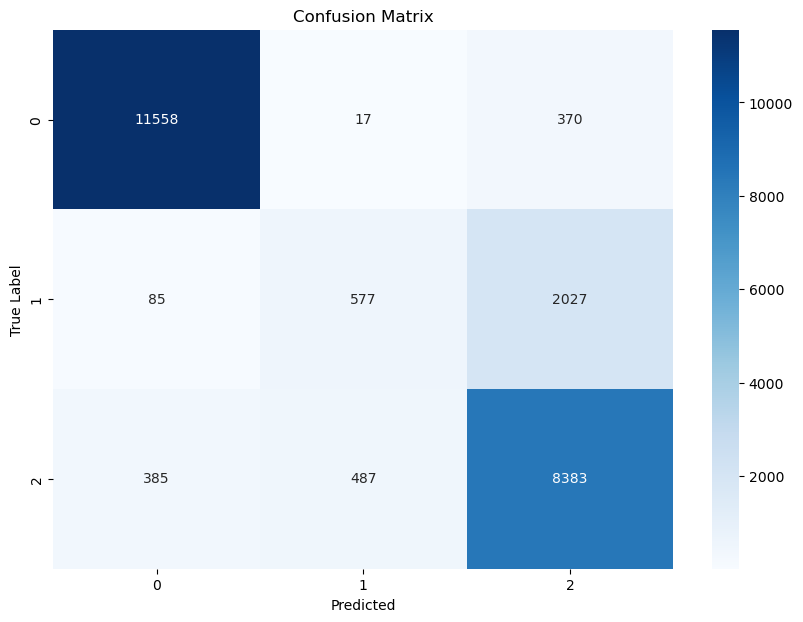

In [6]:
y_pred = np.argmax(y_prob, axis=1)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
auc_score = roc_auc_score(y_test, y_prob, multi_class='ovr', average='micro')
auc_score

0.9664076542940453

In [8]:
for class_i in range(3):
    y_binary = (y_test == class_i).astype(int)
    y_prob_class_i = y_prob[:, class_i]
    class_auc = roc_auc_score(y_binary, y_prob_class_i)

    print('class', class_i, class_auc)
    

class 0 0.9943091725386813
class 1 0.857248994856754
class 2 0.9287333870997634


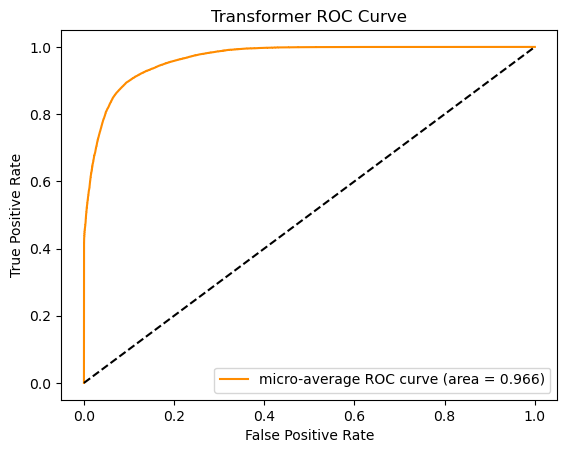

In [9]:
# micro-average ROC curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='micro-average ROC curve (area = {0:0.3f})'.format(roc_auc),
         color='darkorange')

plt.plot([0, 1], [0, 1], 'k--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Transformer ROC Curve')
plt.legend(loc="lower right")
plt.show()

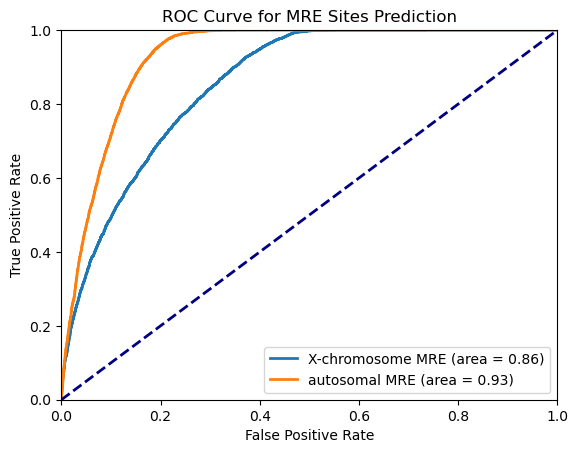

In [40]:
# per class ROC curve
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()

classes = ['control', 'X-chromosome MRE', 'autosomal MRE']
for i, cls in enumerate(classes):
    if i > 0:
        plt.plot(fpr[i], tpr[i], lw=2, 
                label='{0} (area = {1:0.2f})'.format(cls, roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MRE Sites Prediction')
plt.legend(loc="lower right")
plt.show()

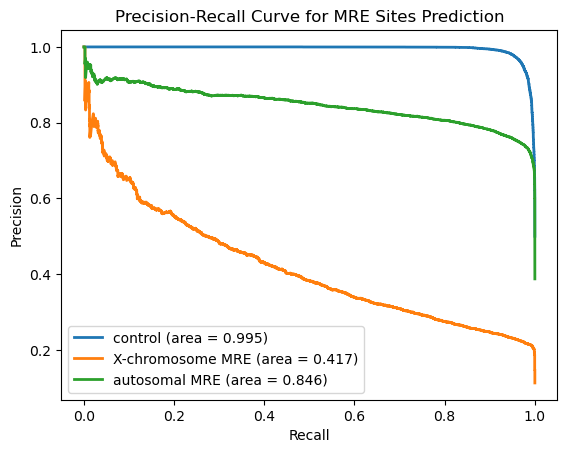

In [43]:
# per class AUPRC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

precision = dict()
recall = dict()
auprc = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    auprc[i] = auc(recall[i], precision[i])

classes = ['control', 'X-chromosome MRE', 'autosomal MRE']
for i, cls in enumerate(classes):
    if i >= 0:
        plt.plot(recall[i], precision[i], lw=2, 
                label='{0} (area = {1:0.3f})'.format(cls, auprc[i]))
        
# plt.xlim([0, 1])
# plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for MRE Sites Prediction')
plt.legend(loc="lower left")
plt.show()

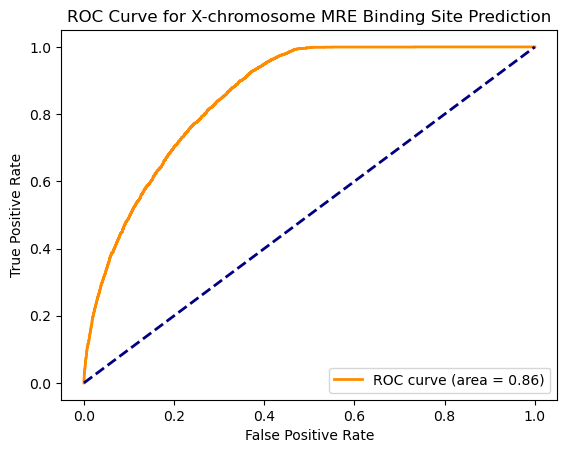

In [13]:
fpr, tpr, _ =  roc_curve(y_test==1, y_prob[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for X-chromosome MRE Binding Site Prediction')
plt.show()

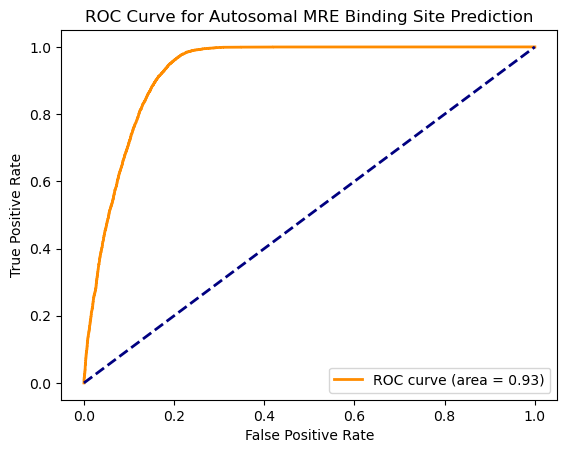

In [14]:
fpr, tpr, _ =  roc_curve(y_test==2, y_prob[:, 2])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for Autosomal MRE Binding Site Prediction')
plt.show()